# Finite State Machine Analysis

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [37]:
def sfun(x):
    #return (("Forsa Hartmoor" in str(x['IB Site Name'])) and 
    return (("Landshut" in str(x['IB Site Name'])) and 
        (x['OperationalCondition'] != 'Decommissioned') and
        (x['Engine ID'] == 'M4'))

res = mp.search_installed_fleet(sfun)
res = res.sort_values(by = "Engine ID",ascending=True)
res.T;

In [38]:
#dval = mp.def_from_installed_fleet(res)
#dval.T

In [39]:
# Ammerlaan Flowers 2, J420 Frage von David Sepulveda Lopez
#e=dmyplant2.Engine.from_sn(mp,5640011)
#dval.iloc[0]['serialNumber']
#e=dmyplant2.Engine.from_sn(mp,dval.iloc[0]['serialNumber'])
e=dmyplant2.Engine.from_fleet(mp,res.iloc[0])

In [40]:
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,BMW Landshut 4.10 M4,M4,U781,624,H01,24,4587.2,24.5,1320072,117617,18025.0,2019-01-09,1384,16641,0.0865


In [41]:
from dfsm import msgFSM
fsm_data = []
#fsm = msgFSM(e, skip_day=7)
#fsm = msgFSM(e, p_from='2022-01-11')
fsm = msgFSM(e, p_from='2021-01-01')
fsm.run() # run Finite State Machine
fsm_data.append({'engine':e, 'fsm':fsm})

Calculating '9047 target load reached' Message.
load ramp assumed to 0.72 %/sec based on rP_Ramp_Set Parameter


FSM: 100%|██████████████████████| 41627/41627 [00:03<00:00, 13554.71 messages/s]


Load Data: 50000 datarows [00:02, 24384.13 datarows/s]                          


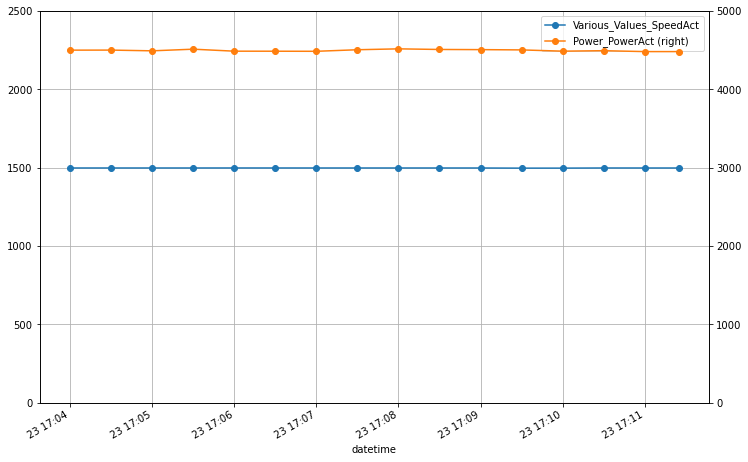

In [42]:
fsm.plot_ts(1637687335601, cycletime=30, marker='o', ylim=(0,2500), figsize=(12,8));
plt.show()

In [43]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
print(f"""
*****************************************
** {str(res['engine'])} **
*****************************************""")
print(f"{'Meldung':9} '{'9047 target load reached'}' {'gefunden.' if any(res['fsm']._messages['name'] == '9047') else 'wird berechnet.'}")
print(f"{'Zeitraum':9}: {res['fsm'].first_message:%d.%m.%Y} bis {res['fsm'].last_message:%d.%m.%Y}")
print(f"{'Dauer':9}: {res['fsm'].period.days:5} Tage")
print(f"{'GESAMT':9}: {res['result'].shape[0]:5} Starts, {res['result'][res['result'].success].shape[0]:5} erfolgreich => {(res['result'][res['result'].success].shape[0] / res['result'].shape[0]) * 100.0:3.1f} % der Starts erfolgreich.")
for mode in ['???','OFF','MANUAL', 'AUTO']:
    lstarts = res['result'][res['result']['mode'] == mode].shape[0]
    successful_starts = res['result'][((res['result'].success) & (res['result']['mode'] == mode))].shape[0]
    print(f"{mode:9}: {lstarts:5} Starts, {successful_starts:5} erfolgreich => {(successful_starts / lstarts) * 100.0 if lstarts != 0 else 0.0:3.1f} % der Starts erfolgreich.")
#res['filtered_result'][['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));


*****************************************
** 1320072 BMW Landshut 4.10 M4 **
*****************************************
Meldung   '9047 target load reached' wird berechnet.
Zeitraum : 01.01.2021 bis 23.02.2022
Dauer    :   418 Tage
GESAMT   :   348 Starts,   288 erfolgreich => 82.8 % der Starts erfolgreich.
???      :     0 Starts,     0 erfolgreich => 0.0 % der Starts erfolgreich.
OFF      :     7 Starts,     3 erfolgreich => 42.9 % der Starts erfolgreich.
MANUAL   :    19 Starts,     4 erfolgreich => 21.1 % der Starts erfolgreich.
AUTO     :   321 Starts,   281 erfolgreich => 87.5 % der Starts erfolgreich.


In [44]:
rdf = res['result']
# filter als pleased :-)
#rda = rdf
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True))]
#rda = rdf[((rdf['mode'] == 'AUTO') & (rdf['success'] == True) & (rdf['synchronize'] < 300.0) & (rdf['start-preparation'] < 300.0))]
#rda = rdf[((rdf['success'] == True) & (rdf['start-preparation'] < 1000.0))]
rda = rdf[((rdf['success'] == True))]
rda[fsm.filter_content].round(2)

,success,mode,start-preparation,starter,hochlauf,idle,synchronize,load-ramp,cumstarttime,target-operation
14,True,AUTO,263.80,4.33,20.19,6.50,6.51,138.89,440.23,0 days 00:40:34
17,True,AUTO,344.13,4.32,14.95,6.76,8.37,138.89,517.43,4 days 07:21:22
18,True,AUTO,320.62,4.74,15.42,6.16,6.96,138.89,492.79,0 days 00:11:12
19,True,AUTO,263.68,4.74,14.92,6.24,21.48,138.89,449.94,5 days 15:31:08
20,True,AUTO,263.44,5.34,14.21,6.44,19.57,138.89,447.89,0 days 00:14:09
...,...,...,...,...,...,...,...,...,...,...
343,True,AUTO,261.74,4.54,14.13,6.56,17.08,138.89,442.95,0 days 00:15:22
344,True,AUTO,261.62,6.24,13.00,6.35,20.20,138.89,446.30,0 days 02:36:50
345,True,AUTO,261.84,4.44,14.61,6.37,27.53,138.89,453.68,0 days 00:17:39
346,True,AUTO,261.58,4.95,14.02,6.47,19.39,138.89,445.29,0 days 02:18:03


In [45]:
rdf_off = rdf[((rdf['mode'] == 'OFF') & (rdf['success'] == True))]
rdf_off[fsm.filter_content].reset_index(drop='index')


,success,mode,start-preparation,starter,hochlauf,idle,synchronize,load-ramp,cumstarttime,target-operation
0,True,OFF,318.615,5.049999,13.604,73.976000,1.918000,138.888,552.051000,0 days 00:04:34
1,True,OFF,261.599,4.672999,15.704,6.952999,14.620000,138.888,442.436999,0 days 00:15:48
2,True,OFF,261.516,5.838999,17.957,7.676999,17.744999,138.888,449.621999,4 days 07:29:45


In [46]:
rdf_off.reset_index(drop='index')

,success,mode,starttime,endtime,cumstarttime,alarms,warnings,start-preparation,starter,hochlauf,idle,synchronize,load-ramp,target-operation
0,True,OFF,2021-03-16 08:22:27.184000000,2021-03-16 08:36:12.838000128,552.051000,[],"[{'state': 'load-ramp', 'msg': [34896, 117617,...",318.615,5.049999,13.604,73.976000,1.918000,138.888,0 days 00:04:34
1,True,OFF,2021-07-08 07:45:47.223000064,2021-07-08 08:08:57.220999936,442.436999,[],"[{'state': 'target-operation', 'msg': [22702, ...",261.599,4.672999,15.704,6.952999,14.620000,138.888,0 days 00:15:48
2,True,OFF,2021-08-24 12:59:42.791000064,2021-08-28 20:36:57.350000128,449.621999,[],"[{'state': 'target-operation', 'msg': [16435, ...",261.516,5.838999,17.957,7.676999,17.744999,138.888,4 days 07:29:45


In [47]:
von=1595464000276
bis=1595546801847
data = fsm.get_period(von, bis, cycletime=30, marker='o', ylim=(0,2500), figsize=(12,8))
data


Load Data: 50000 datarows [00:00, 194179.30 datarows/s]                         


,time,Power_PowerAct,Various_Values_SpeedAct,datetime
0,1595464000000,3529.6358,1498.971600,2020-07-23 00:26:40
1,1595464020000,3531.1291,1498.745267,2020-07-23 00:27:00
2,1595464050000,3538.0000,1499.000000,2020-07-23 00:27:30
3,1595464080000,3538.0000,1499.000000,2020-07-23 00:28:00
4,1595464110000,3538.0000,1499.000000,2020-07-23 00:28:30
...,...,...,...,...
2757,1595546700000,0.0000,0.000000,2020-07-23 23:25:00
2758,1595546730000,0.0000,0.000000,2020-07-23 23:25:30
2759,1595546760000,0.0000,0.000000,2020-07-23 23:26:00
2760,1595546790000,0.0000,0.000000,2020-07-23 23:26:30


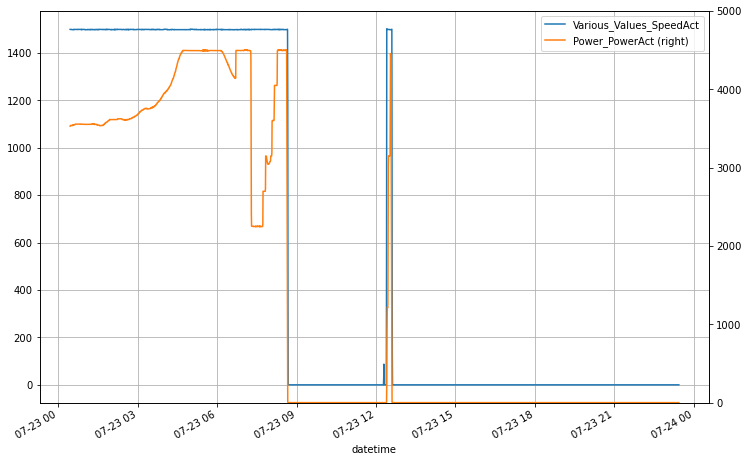

In [48]:
fsm._plot(data, figsize=(12,8))
plt.show()

In [49]:
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000)},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
]
dmyplant2.dbokeh_chart(data, dset, title=fsm._e, figsize=(12,8))

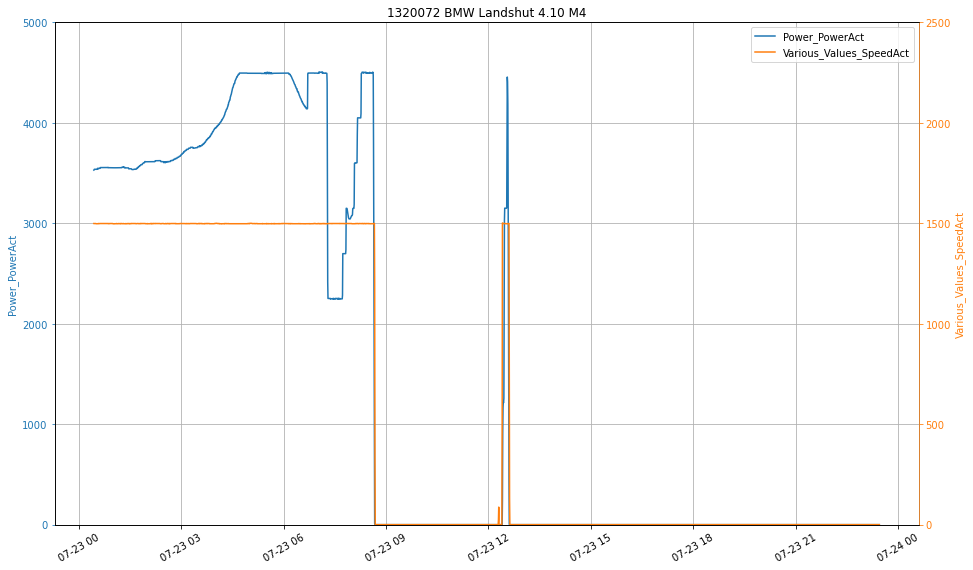

In [50]:
dmyplant2.chart(data, dset, title=fsm._e, figsize=(15,9))

In [51]:
rec = next(rdf_off[fsm.filter_times].itertuples(name='Result'))
rec

Result(Index=56, _1=318.615, starter=5.049999, hochlauf=13.604, idle=73.976, synchronize=1.9180000000000001, _6=138.888, cumstarttime=552.051)

In [52]:
# duration = 0.0
# for k in list(fsm.states.keys())[1:-1]:
#     dtt=rec[k]
#     if dtt == dtt:
#         #ax.axvline(arrow.get(rec['starttime']).shift(seconds=duration).datetime, color="red", linestyle="--", label=f"{duration:4.1f}")
#         duration = duration + dtt
#     else:
#         break

Load Data: 50000 datarows [00:00, 264729.41 datarows/s]                         


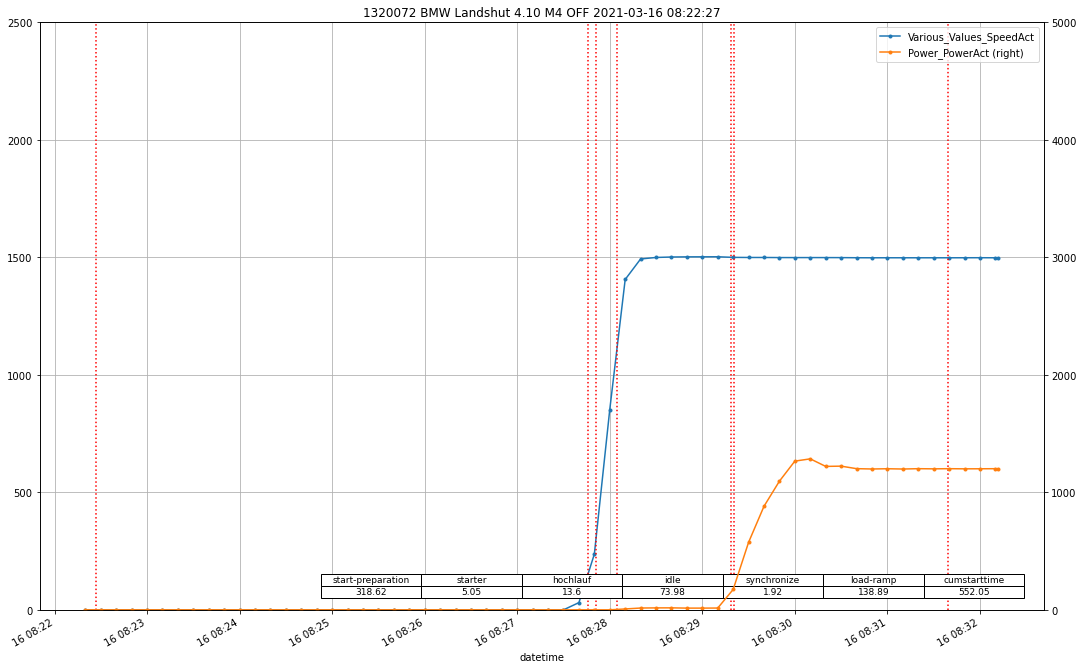

Load Data: 50000 datarows [00:00, 268058.03 datarows/s]                         


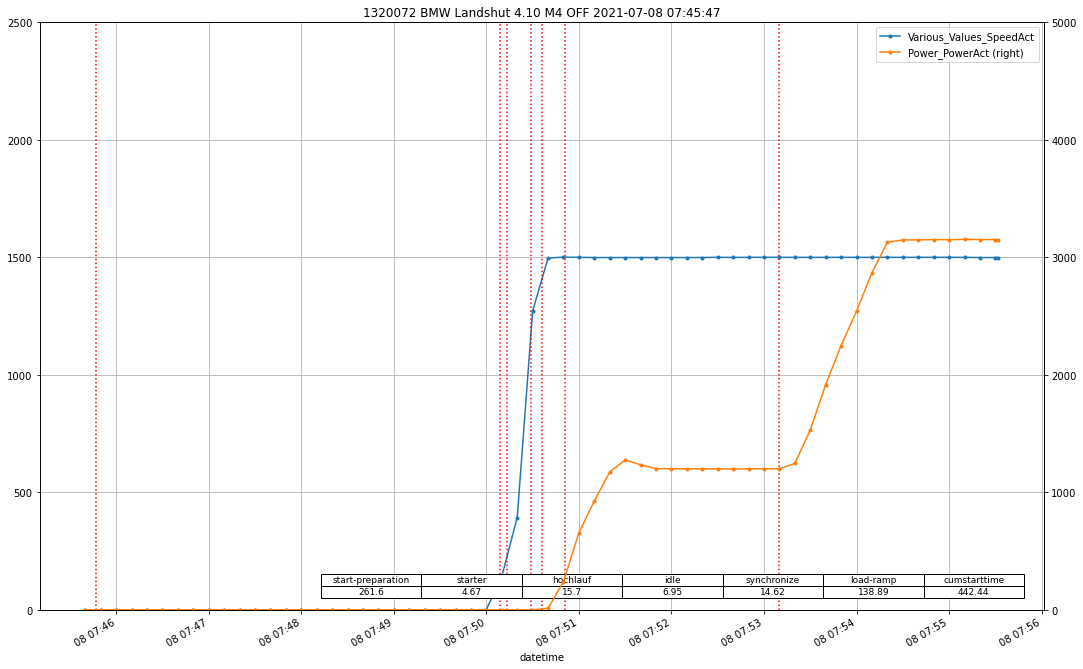

Load Data: 50000 datarows [00:00, 269335.60 datarows/s]                         


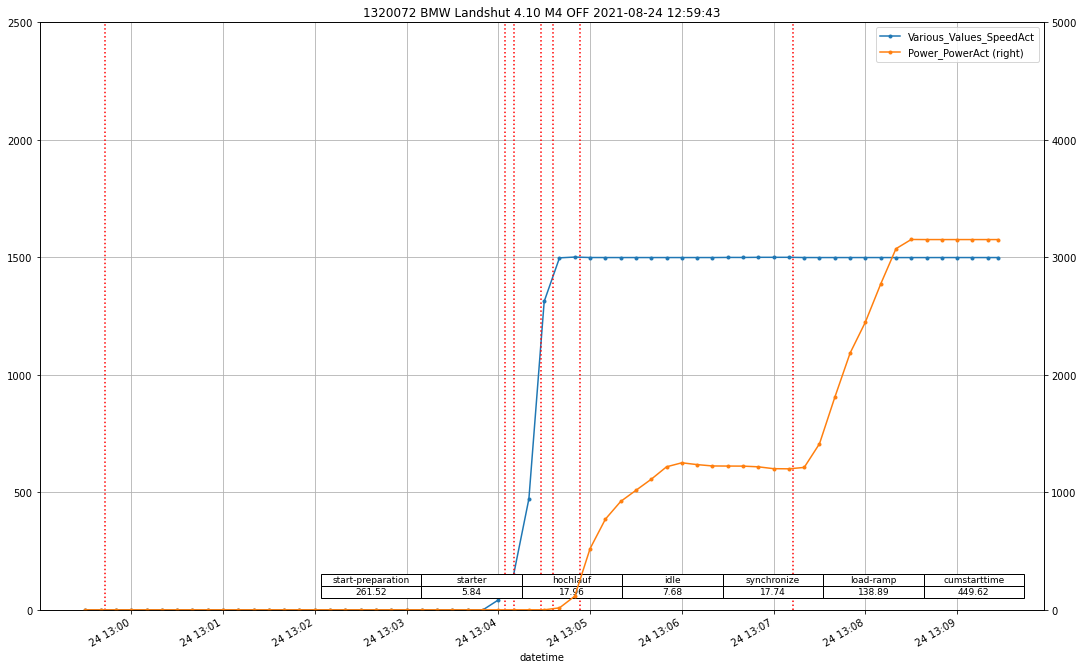

In [53]:
for i,r in rdf_off.iterrows():
    r_summary = pd.DataFrame(r[fsm.filter_times], dtype=np.float64).round(2).T
    #fsm.plot_cycle(r, max_length=20*60, ylim=(0,2500), cycletime=1, marker=None, figsize=(16,10), title=f"{fsm._e} {r['mode']} {r['starttime'].round('S')}");
    fsm.plot_cycle(r, max_length=10*60, ylim=(0,2500), cycletime=10, style='.-', figsize=(18,12), title=f"{fsm._e} {r['mode']} {r['starttime'].round('S')}");
    plt.show()

In [54]:
rda.describe().round(2).T;

In [55]:
longer_than_300s = rda[fsm.filter_period + fsm.filter_content][rdf['cumstarttime'] > 300.0]
longer_than_300s[fsm.filter_content].round(2);

In [56]:
#for i, r in longer_than_300s.iterrows():
#    fsm.plot_cycle(r, max_length=20*60, ylim=(0,5000), title=f"{fsm._e}{r['starttime'].round('S')}: cumstarttime: {r['cumstarttime']}s");

In [57]:
longer_than_300s.describe().round(2).T;

In [58]:
load_ramp_less_than_100s = rda[fsm.filter_period + fsm.filter_content][rdf['load-ramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filter_content].reset_index(drop='index').round(2)
lfsm

,success,mode,start-preparation,starter,hochlauf,idle,synchronize,load-ramp,cumstarttime,target-operation


In [59]:
rda.reset_index(drop='index').iloc[10];

Load Data: 50000 datarows [00:00, 233304.89 datarows/s]                         


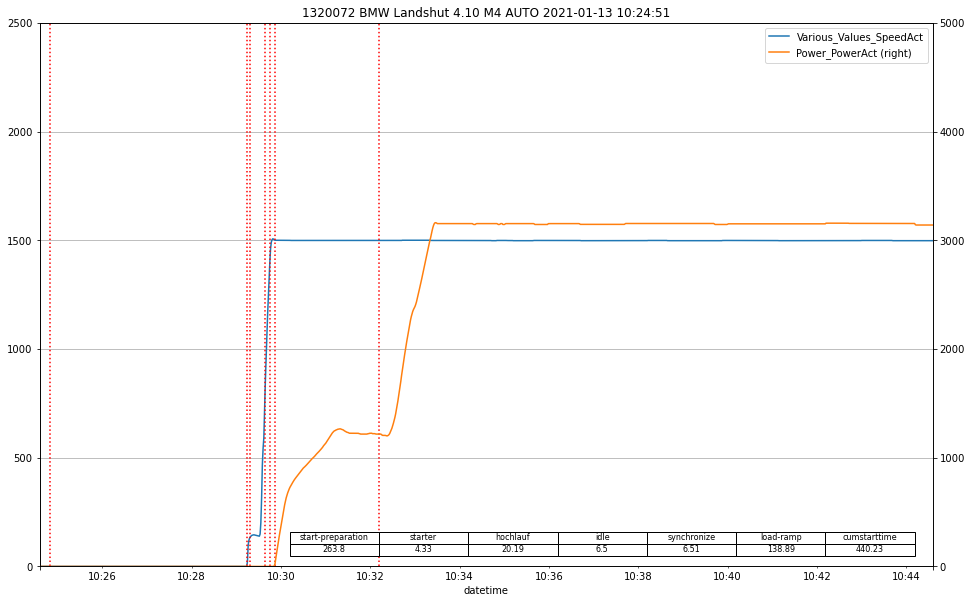

Load Data: 50000 datarows [00:00, 226691.44 datarows/s]                         


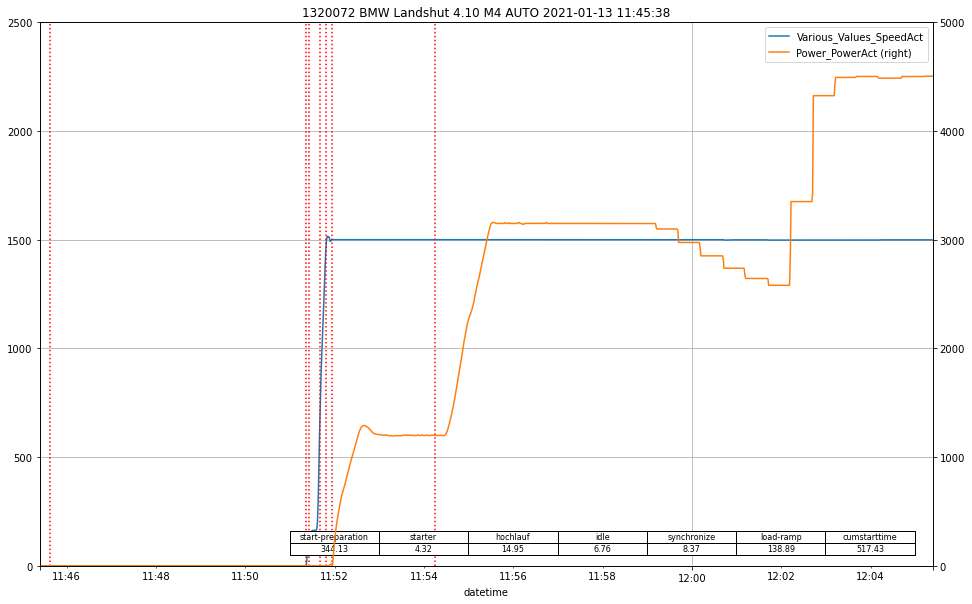

Load Data: 50000 datarows [00:00, 235511.48 datarows/s]                         


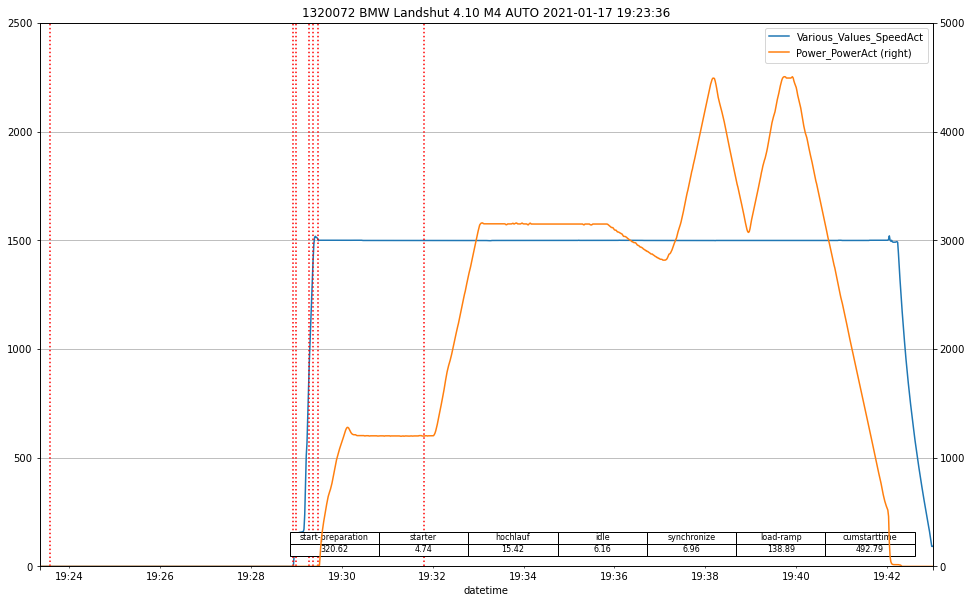

Load Data: 50000 datarows [00:00, 241078.83 datarows/s]                         


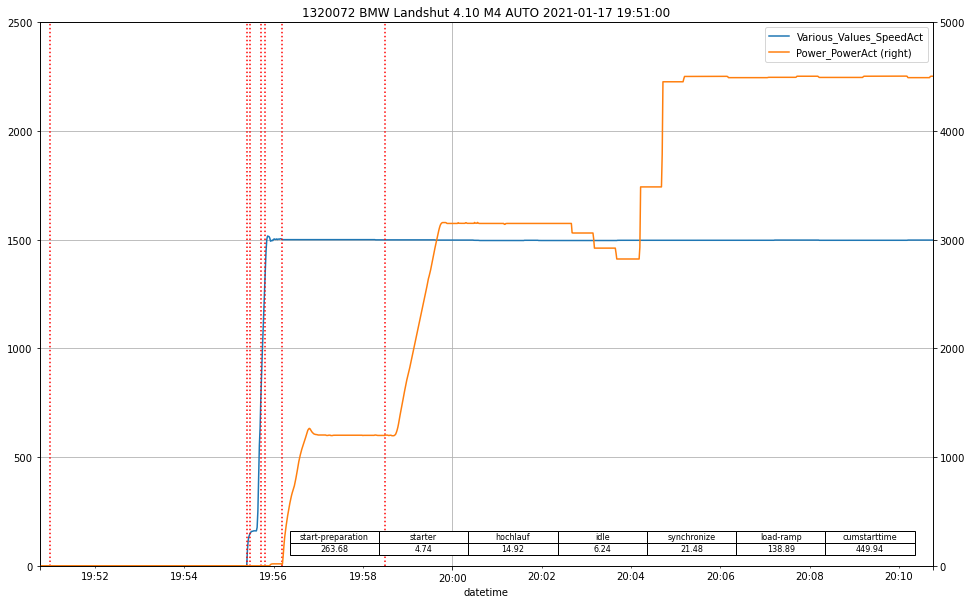

Load Data: 50000 datarows [00:00, 229004.73 datarows/s]                         


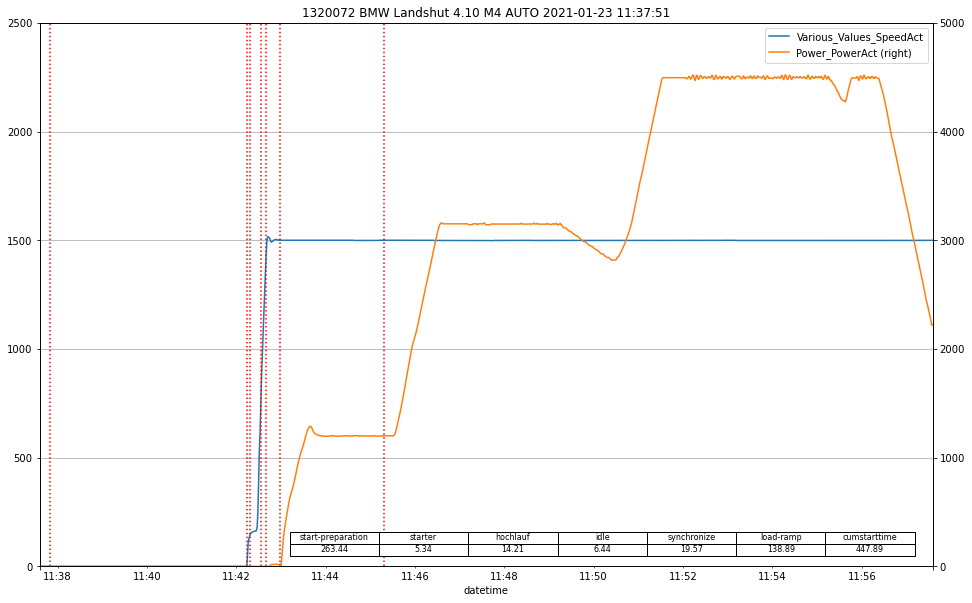

In [60]:
#r = load_ramp_less_than_100s.reset_index(drop='index').iloc[0]
for i in np.arange(0,5):
    r = rda.reset_index(drop='index').iloc[i]
    r_summary = pd.DataFrame(r[fsm.filter_times], dtype=np.float64).round(2).T
    fsm.plot_cycle(r, max_length=20*60, ylim=(0,2500), cycletime=1, marker=None, figsize=(16,10), title=f"{fsm._e} {r['mode']} {r['starttime'].round('S')}");
    plt.show()

In [61]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [62]:
load_ramp_less_than_100s.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
start-preparation,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
starter,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
hochlauf,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
idle,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
synchronize,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
load-ramp,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
cumstarttime,0.0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
target-operation,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT


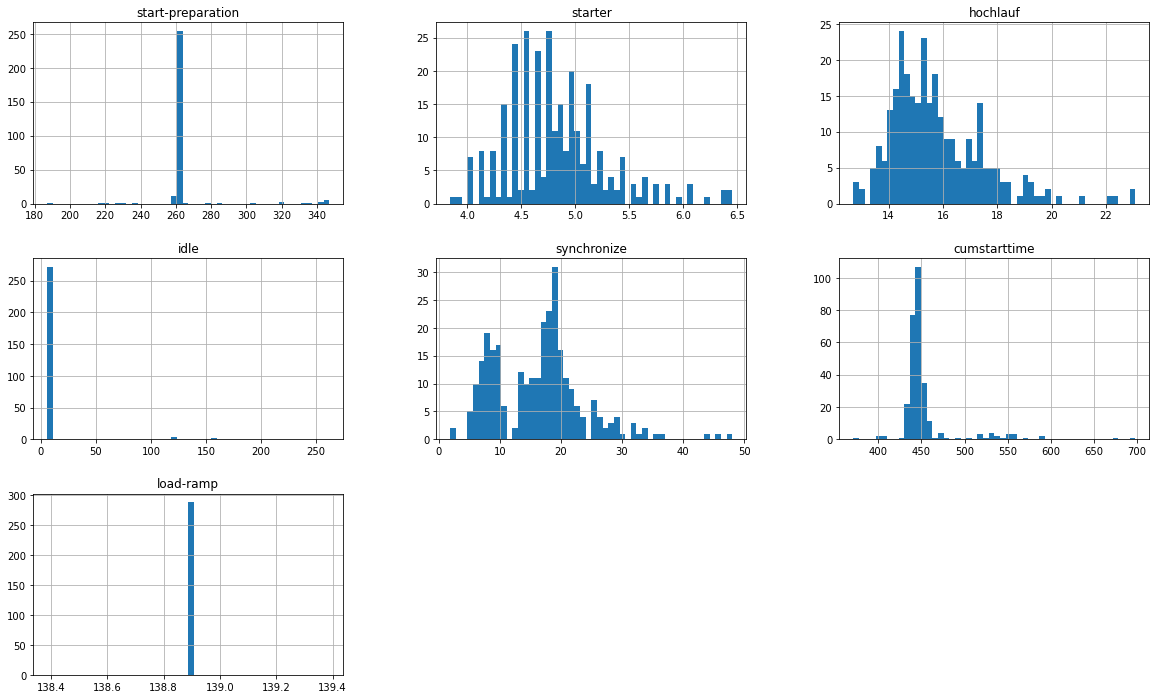

In [63]:
rda[['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [64]:
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');


Startversuch: 0, Success: False
0                 load-ramp            1609571802466 02.01.2021 07:16:42 1032 Heating water flow low


Load Data: 50000 datarows [00:00, 154884.07 datarows/s]                         


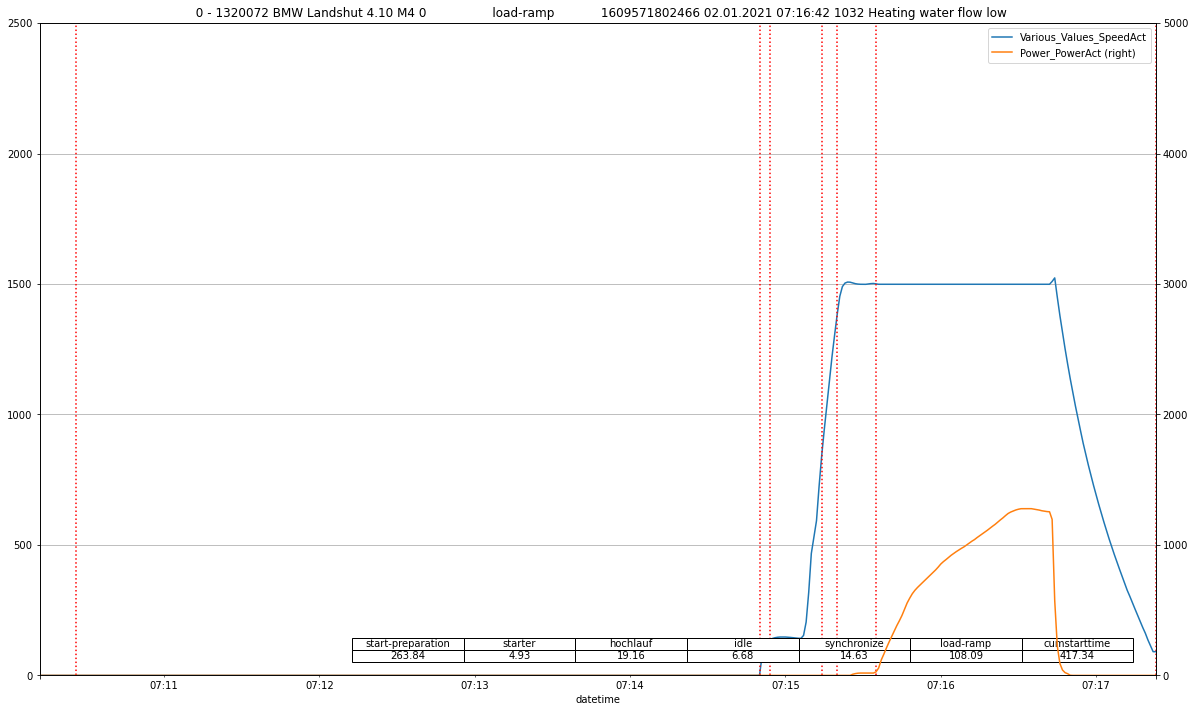

1                 load-ramp            1609571802667 02.01.2021 07:16:42 1056 Fail safe loop tripped


Load Data: 50000 datarows [00:00, 282516.25 datarows/s]                         


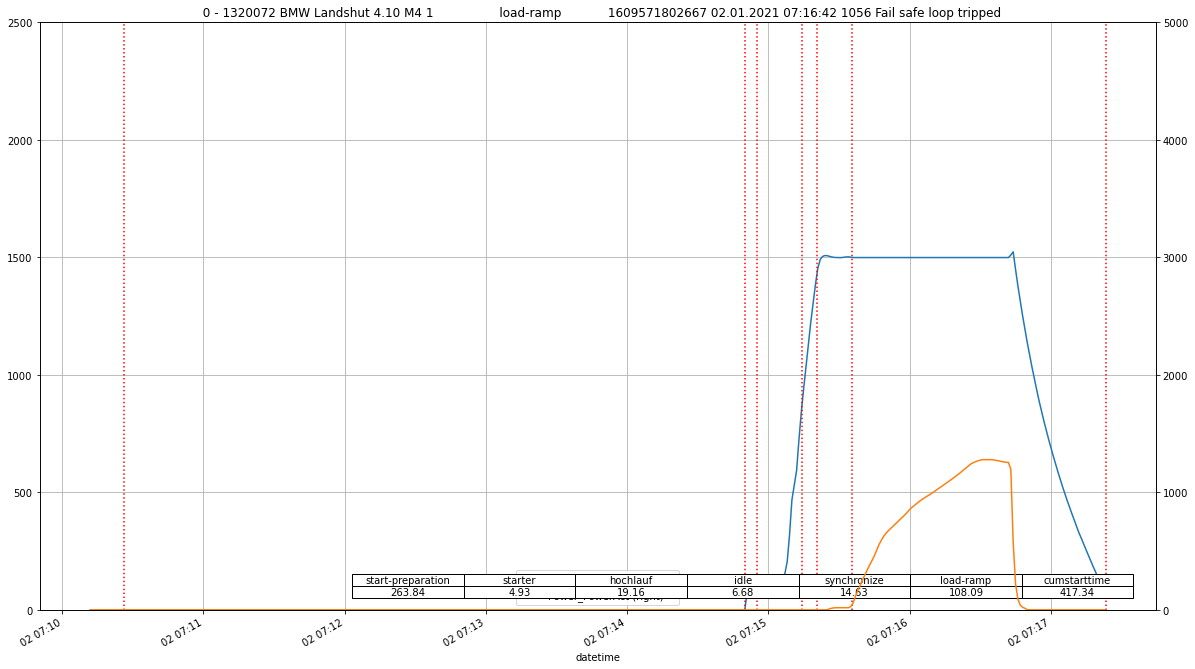


Startversuch: 2, Success: False
2 AUTO            load-ramp            1610117049515 08.01.2021 14:44:09 1032 Heating water flow low
3 AUTO            load-ramp            1610117049717 08.01.2021 14:44:09 1056 Fail safe loop tripped

Startversuch: 3, Success: False
4 AUTO            load-ramp            1610119568015 08.01.2021 15:26:08 1032 Heating water flow low
5 AUTO            load-ramp            1610119568218 08.01.2021 15:26:08 1056 Fail safe loop tripped

Startversuch: 4, Success: False
6 AUTO            load-ramp            1610121068049 08.01.2021 15:51:08 1032 Heating water flow low
7 AUTO            load-ramp            1610121068250 08.01.2021 15:51:08 1056 Fail safe loop tripped

Startversuch: 5, Success: False
8 AUTO            load-ramp            1610123758874 08.01.2021 16:35:58 1032 Heating water flow low
9 AUTO            load-ramp            1610123759075 08.01.2021 16:35:59 1056 Fail safe loop tripped

Startversuch: 6, Success: False
10 AUTO            load-ram

In [65]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 1
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

<Figure size 432x288 with 0 Axes>

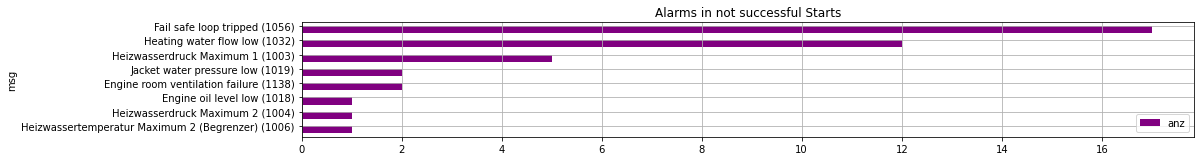

In [66]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

<Figure size 432x288 with 0 Axes>

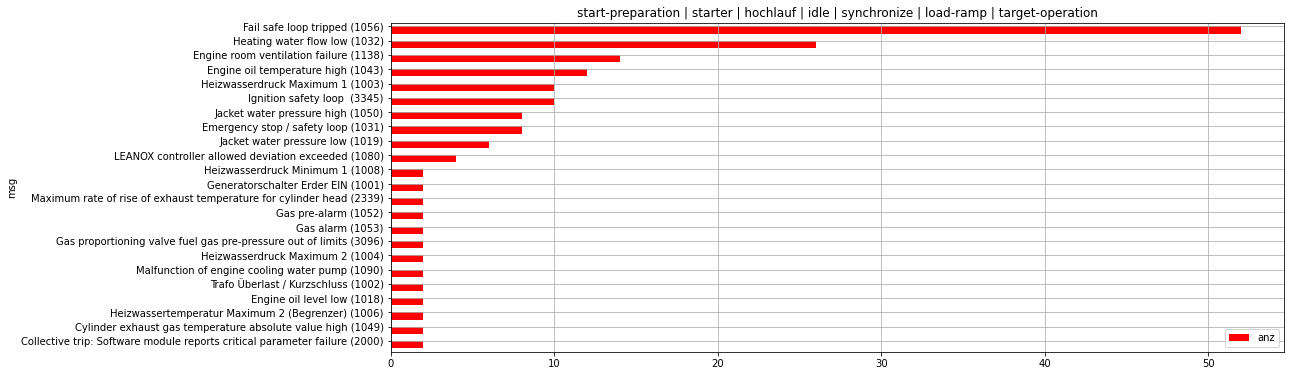

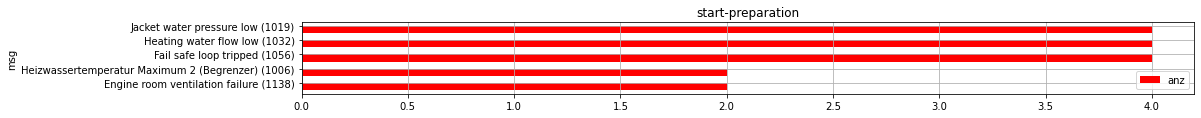

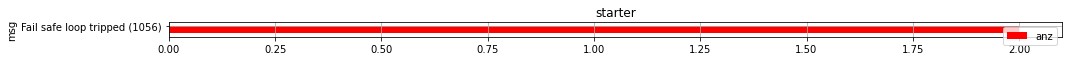

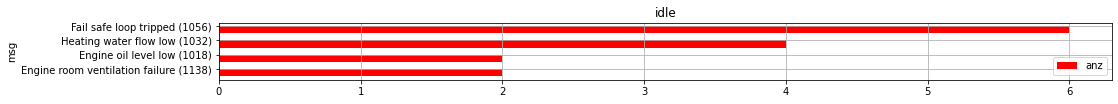

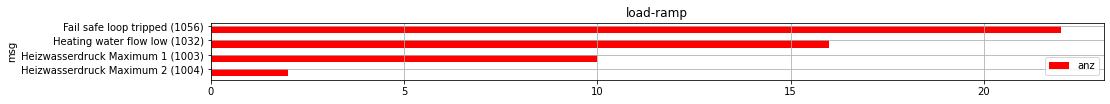

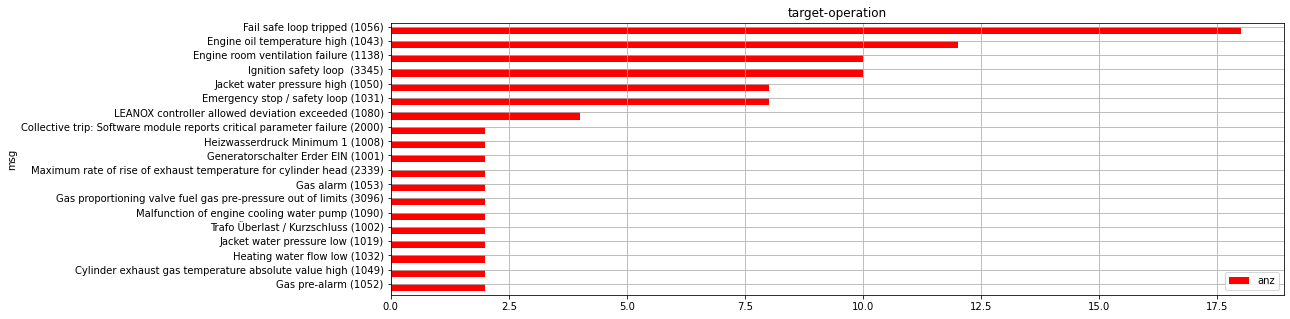

In [67]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


<Figure size 432x288 with 0 Axes>

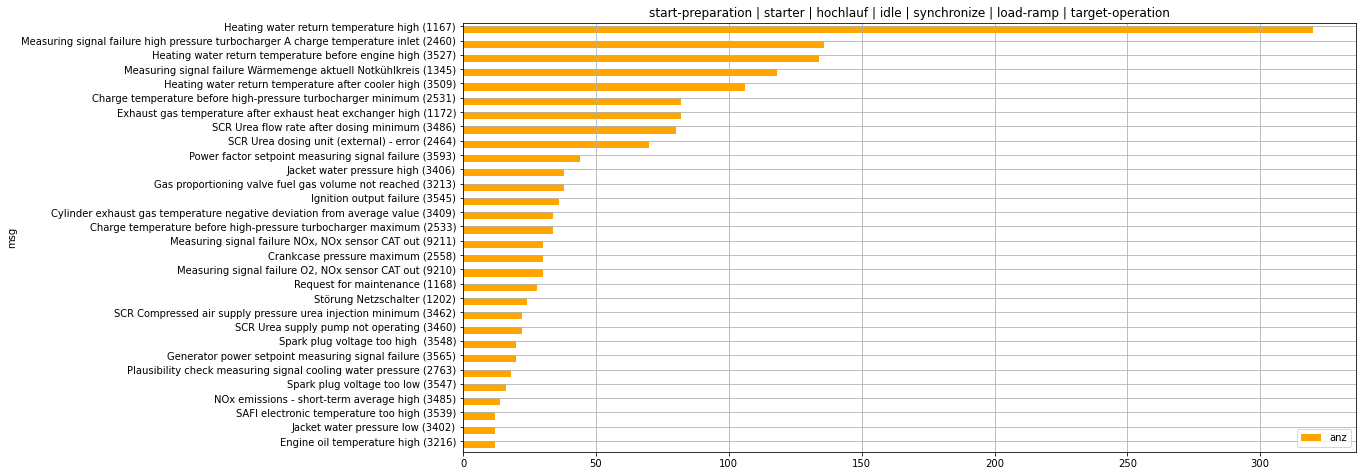

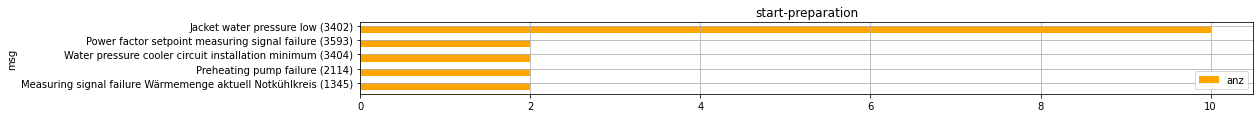

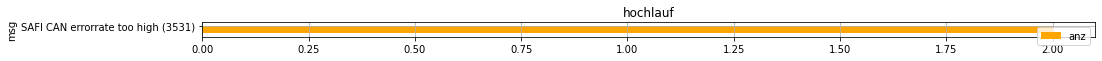

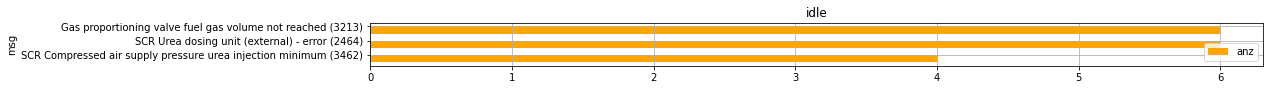

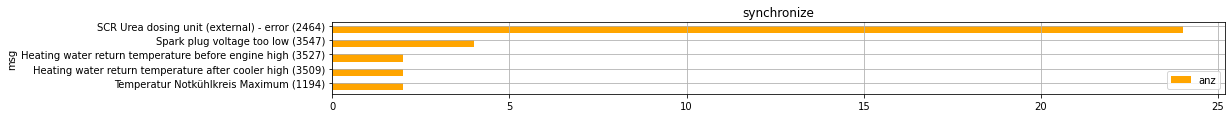

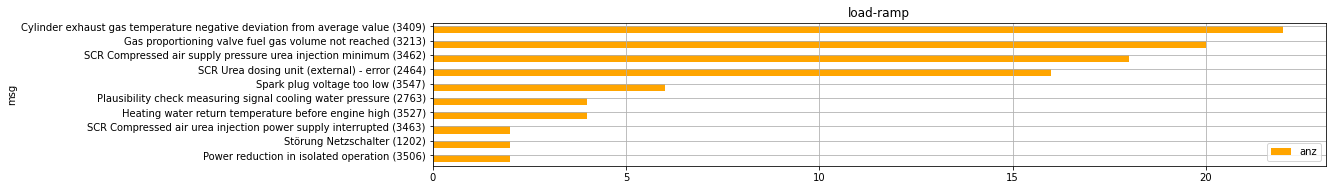

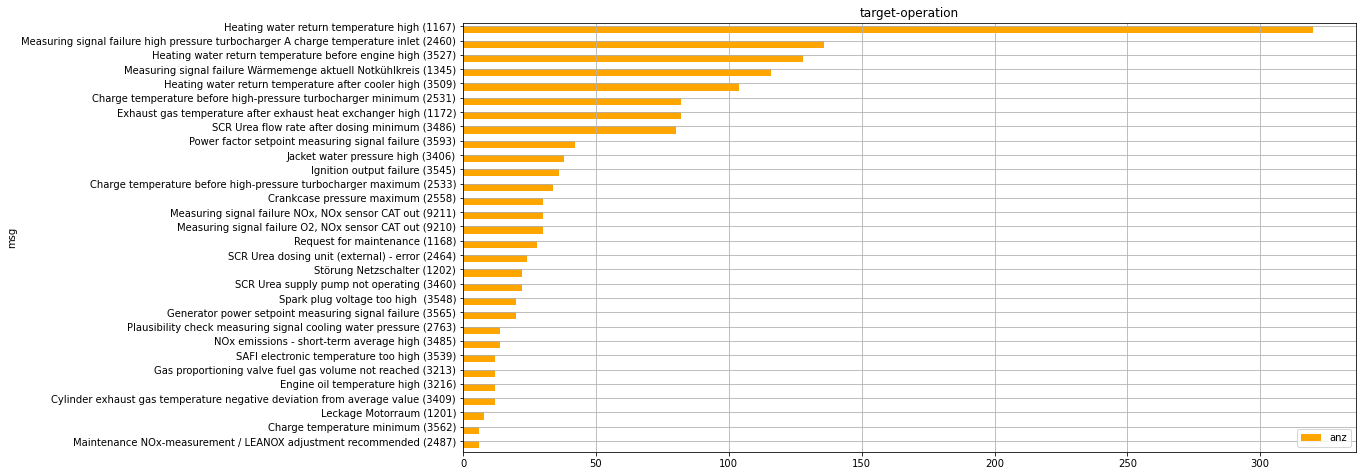

In [68]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [69]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

/Users/dieterchvatal/prog/python3/statemachine/data/1320072/1320072_messages.txt


In [70]:
any(fsm._messages['name'] == '9047')

False